In [1]:
import numpy as np
import pandas as pd
import math
import operator
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import h5py
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# Reading Data

In [2]:
### READING USPS DATA ###
def usps_read(file_name):
    with h5py.File(file_name, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        y_tr = y_tr.reshape((len(y_tr),1))
        data = np.append(X_tr,y_tr,axis=1)
        return data

### READING MNIST DATA ###
def mnist_read(file_name):
    data = pd.read_csv(file_name)
    X = data.loc[:,'1x1':'28x28']
    Y = data['label']
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape((len(Y),1))
    data = np.append(X,Y,axis=1)
    return data


# Collecting Samples 500 each from each View

In [3]:
### GENERATING 500 SAMPLES FOR EACH VIEW ###
def generateSamples(data):
    View = []
    for label in range(10):
        View.append(data[np.where(data[:,-1] == label)][0:50])
    View = np.array(View)
    return View


# Creating Partial Data 20% missing in each view

In [4]:
### PARTIAL DATA GENERATION ###
def generatePartialData(Views):
    size_of_data = 50
    split_c = 0.6    ### COMMON DATA POINTS ###
    split_v1 = 0.2   ### VIEW1 SPLIT ### 
    split_v2 = 0.2   ### VIEW2 SPLIT ###
    ncommon = math.ceil(split_c*size_of_data)

    ### PART COMMON IN BOTH VIEWS ###
    XNc = []
    YNc = []
    for labeled_data in Views[0]:
        XNc.append(labeled_data[0:ncommon,:])
    for labeled_data in Views[1]:
        YNc.append(labeled_data[0:ncommon,:])

    ### PART MISSING IN VIEW 2 ###
    XNx = []
    for labeled_data in Views[0]:
        XNx.append(labeled_data[ncommon:ncommon + math.ceil(split_v1*size_of_data),:])

    ### PART MISSING IN VIEW 1 ###
    YNy = []
    for labeled_data in Views[1]:
        YNy.append(labeled_data[ncommon + math.ceil(split_v1*size_of_data):,:])
    return XNc,YNc,XNx,YNy


# Creating Outliers 10% in each View

In [5]:
### FUNCTION TO GENERATE OUTLIERS IN THE AVAILABLE DATA BY SWAPPING 10% OF THE SAMPLES
def generateOutliers(XNc,XNx):
    X = []
    l1 = [1,2,3,4,7]
    l2 = [9,6,5,8,0]
    outliers_index = np.zeros((10,50))
    for i in range(10):
        X.append(np.concatenate((XNc[i],XNx[i]),axis = 0))    ### CONCATENATING XNX AND XNC ###
    swaps = math.floor(0.1 * X[0].shape[0])    ### 10% OF DATA SWAPPED BETWEEN CLASSES ###
    for i in range(len(l1)):
        swapped_index = random.sample(range(0, X[l1[i]].shape[0]), swaps)
        for j in swapped_index:    ### SWAPPING DATA IN l1 & l2	 CLASSES ###
            temp = np.array(X[l1[i]][j])
            X[l1[i]][j] = np.array(X[l2[i]][j])
            X[l2[i]][j] = temp
            outliers_index[l1[i]][j] = 1
            outliers_index[l2[i]][j] = 1
    for i in range(10):
        XNc[i] = X[i][0:XNc[i].shape[0],:]
        XNx[i] = X[i][XNc[i].shape[0]:,:] 
    return XNc,XNx,outliers_index    ### DATA WITH OUTLIERS ###

# KNN Algorithm

In [6]:
def get_distance(data,train_data,dist_type):
    dist = 0 
    if (dist_type == "euclid"):
        for i in range(len(train_data)-1):
            dist += pow(data[i]-train_data[i],2)
        dist = math.sqrt(dist)
    elif (dist_type == "manhattan"):
        for i in range(len(train_data)-1):
            dist += abs(data[i]-train_data[i])
    elif (dist_type == "minkowski"):
        for i in range(len(train_data)-1):
            dist += abs(data[i]-train_data[i]) ** 3
        dist = dist ** (1.0/3)
    return dist

def eucidean_distance(x,y):
    dist_sq=0
    for i in range(len(x)):
        dist_sq+=math.pow(x[i]-y[i],2)
    return math.sqrt(dist_sq)

def calc_distances(record,train_data):
    distances=[]
    for i in train_data:
        distances.append((eucidean_distance(record,i),i))
    return distances

def get_k_neighbours(distances,k):
    k_neighbours=[]
    distances.sort(key=lambda x: x[0])
    for i in range(k):
        k_neighbours.append(distances[i][1])
    return k_neighbours


def knn_predict(train_data,k):
    neighbour_list = []
    for data in train_data:
        dis = calc_distances(data,train_data)
        neighbours = get_k_neighbours(dis,k)
        neighbour_list.append([data,neighbours])
    return neighbour_list


# Initializing Missing Data with Mean

In [7]:
def initialization(XNc,XNx,YNc,YNy,available_fraction,size):

    XNc = XNc[:,0:XNc.shape[1]-1]
    YNc = YNc[:,0:YNc.shape[1]-1]

    XNx = XNx[:,0:XNx.shape[1]-1]
    YNy = YNy[:,0:YNy.shape[1]-1]

    XNc_XNx = np.concatenate((XNc,XNx),axis = 0)
    YNc_YNy = np.concatenate((YNc,YNy),axis = 0)
    temp = np.mean(XNc_XNx,axis=0)
    temp1 = np.mean(YNc_YNy,axis=0)

    XNy = np.full((math.ceil(size*(1-available_fraction)/2),XNx.shape[1]),temp) 	### INITIALIZING XNy WITH AVERAGE VALUES ###
    
    YNx = np.full((math.ceil(size*(1-available_fraction)/2),YNy.shape[1]),temp1)	### INITIALIZING YNx WITH AVERAGE VALUES ###

    return XNc,XNx,XNy,YNc,YNy,YNx

# Missing Data Generation and Outlier Detection

In [8]:
def sampleRecover_OutlierDetection(XNc,XNx,XNy,YNc,YNy,YNx,size,available_fraction,T,k):
    missing_fraction = (1 - available_fraction)/2
    X = np.concatenate((XNc,XNx),axis = 0)
    X = np.concatenate((X,XNy),axis = 0)

    Y = np.concatenate((YNc,YNx),axis = 0)
    Y = np.concatenate((Y,YNy),axis = 0)
#     print("Shape of Y view ",Y.shape)

    ### HSIC ###
    ones_vec = np.array(([1]*size))
    ones_vec = ones_vec.reshape((ones_vec.shape[0],1))
    
    H = np.identity(size) - 1/size * (np.dot(ones_vec,ones_vec.T))
    H = H/(size-1)
    C = np.dot(ones_vec,ones_vec.T)
    
    for i in range(T):
        print("Iteration ",i,"/",T)
        diag_C = np.diag(np.diag(C))
        
        error_y, error_x = 1, 1
        for j in range(500): ###  FOR CONVERGENCE ###
            P = np.dot(diag_C,np.dot(np.dot(H,X),np.dot(X.T,H))) 
            PNcNx = P[int(size * available_fraction) : int(size * (missing_fraction + available_fraction)),0:int(size * available_fraction)]
            PNxNx = P[int(size * available_fraction) : int(size * (missing_fraction + available_fraction)),int(size * available_fraction) : int(size * (missing_fraction + available_fraction))]
            PNxNy = P[int(size * available_fraction) : int(size * (missing_fraction + available_fraction)),int(size * (available_fraction+missing_fraction)) : int(size * (2*missing_fraction + available_fraction))]

            ### TO GUARANTEE THE INVERTIBILITY, WE USUALLY ADD A SMALL PERTURBATION OF 10^-6 TO EACH MAIN DIAGONAL ELEMENT OF PNxNx ###
            a = np.zeros((PNxNx.shape[0], PNxNx.shape[1]), float)
            np.fill_diagonal(a, 0.000001)
            PNxNx = PNxNx + a

            YNx_old = copy.deepcopy(YNx)
            YNx = -1 * np.dot(np.linalg.inv(PNxNx),(np.dot(PNcNx,YNc) + np.dot(PNxNy,YNy)))
            error_y = mean_squared_error(YNx_old,YNx)

            Y = np.concatenate((YNc,YNx),axis = 0)
            Y = np.concatenate((Y,YNy),axis = 0)

            Q = np.dot(diag_C,np.dot(np.dot(H,Y),np.dot(Y.T,H)))
            QNcNy = Q[int(size * (available_fraction+missing_fraction)) :,0:int(size * available_fraction)]
            QNxNy = Q[int(size * (available_fraction + missing_fraction)) :,int(size * available_fraction) : int(size * (missing_fraction + available_fraction))]
            QNyNy = Q[int(size * (available_fraction+missing_fraction)) :,int(size * (available_fraction+missing_fraction)) : int(size * (2*missing_fraction + available_fraction))]
            
            XNy_old = copy.deepcopy(XNy)
            XNy = -1 * np.dot(np.linalg.inv(QNyNy),(np.dot(QNcNy,XNc) + np.dot(QNxNy,XNx)))
            error_x = mean_squared_error(XNy_old,XNy)

            X = np.concatenate((XNc,XNx),axis = 0)
            X = np.concatenate((X,XNy),axis = 0)

        print("After convergence error in XNy and YNx view is - ",error_x,error_y)

        ###KNN
        neighbour_list =  knn_predict(X,k)
        WX = np.zeros(shape =(size,size))
        for i in range(size):
            for j in range(size):
                if any(np.array_equal(x, neighbour_list[i][0]) for x in neighbour_list[j][1]):
                    WX[i][j] = 1
                    WX[j][i] = 1
                if any(np.array_equal(x, neighbour_list[j][0]) for x in neighbour_list[i][1]):
                    WX[i][j] = 1
                    WX[j][i] = 1

        neighbour_list =  knn_predict(Y,k)

        WY = np.zeros(shape =(size,size))
        for i in range(size):
            for j in range(size):
                if any(np.array_equal(x, neighbour_list[i][0]) for x in neighbour_list[j][1]) or any(np.array_equal(x, neighbour_list[j][0]) for x in neighbour_list[i][1]):
                    WY[i][j] = 1
                    WY[j][i] = 1
                if any(np.array_equal(x, neighbour_list[j][0]) for x in neighbour_list[i][1]):
                    WY[i][j] = 1

        s = np.dot(np.dot(H,WX),np.dot(H,WY))
        s = s.diagonal()
        s = np.interp(s, (s.min(), s.max()), (0.1, 1))
        S = np.zeros(shape =(size,size))
        np.fill_diagonal(S, s)
        C = np.dot(S,S.T)

    return S.diagonal(),X,Y

Set  0
X-view


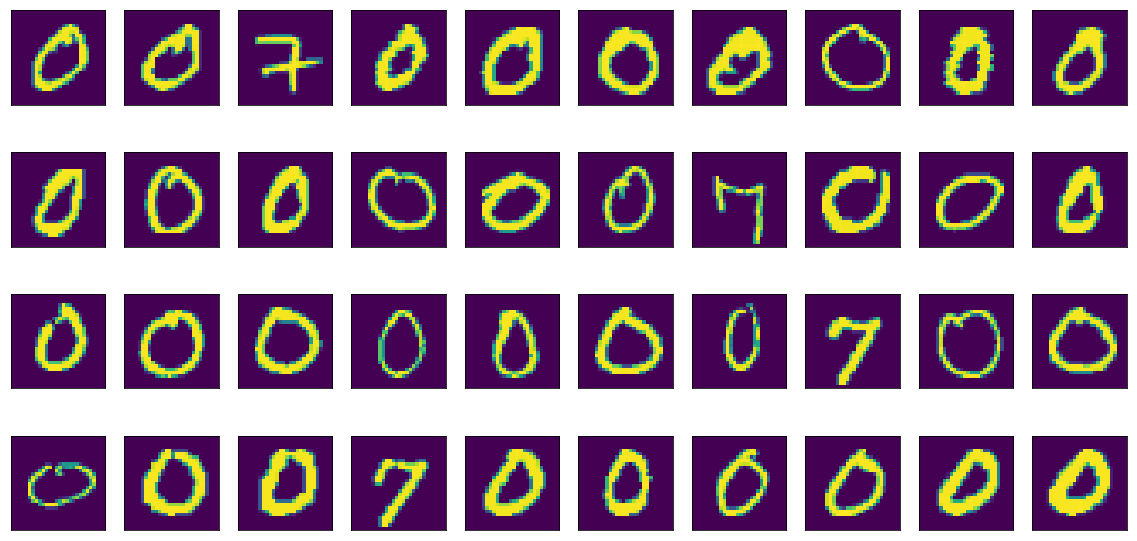

Y-view


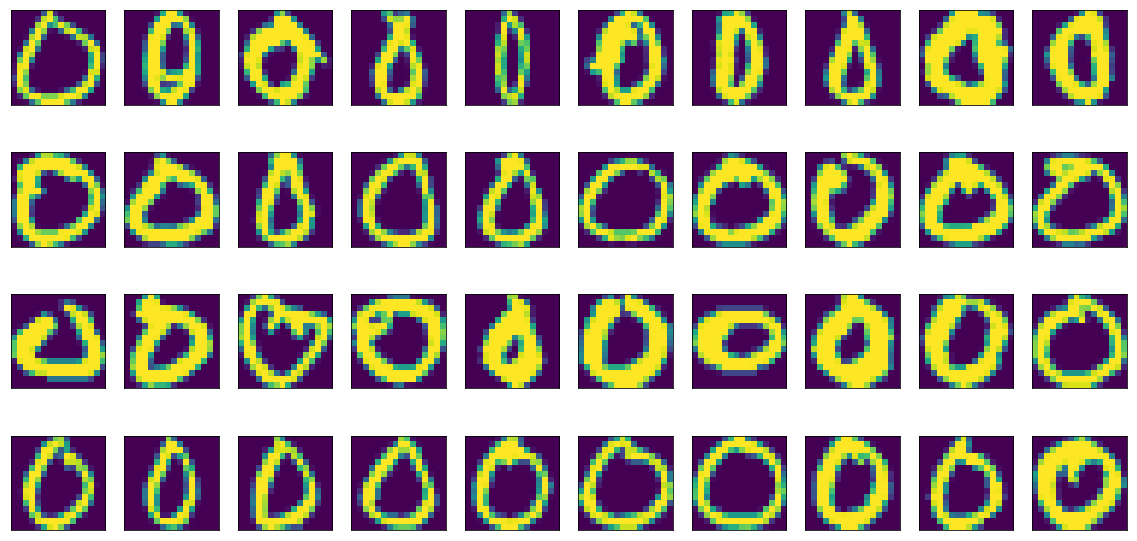

Iteration  0 / 100
After convergence error in XNy and YNx view is -  1.033349166684001e-14 9.462577783764645e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  1.8307891478905418e-11 2.4151143587562546e-15
Iteration  2 / 100
After convergence error in XNy and YNx view is -  1.8304130216091403e-11 2.414568421648154e-15
Iteration  3 / 100
After convergence error in XNy and YNx view is -  1.8300367897370215e-11 2.414022420398613e-15
Iteration  4 / 100
After convergence error in XNy and YNx view is -  1.8296609672123815e-11 2.4134768357805066e-15
Iteration  5 / 100
After convergence error in XNy and YNx view is -  1.829284863364748e-11 2.4129310474604983e-15
Iteration  6 / 100
After convergence error in XNy and YNx view is -  1.8289092290571345e-11 2.4123858531748075e-15
Iteration  7 / 100
After convergence error in XNy and YNx view is -  1.828533237790963e-11 2.4118401886859093e-15
Iteration  8 / 100
After convergence error in XNy and YNx view is -  1.828157582243616

Iteration  72 / 100
After convergence error in XNy and YNx view is -  1.8042823561081053e-11 2.3766633729220595e-15
Iteration  73 / 100
After convergence error in XNy and YNx view is -  1.8039118442122445e-11 2.3761262959532722e-15
Iteration  74 / 100
After convergence error in XNy and YNx view is -  1.8035413772186503e-11 2.3755892375894014e-15
Iteration  75 / 100
After convergence error in XNy and YNx view is -  1.803171278885114e-11 2.375052660356802e-15
Iteration  76 / 100
After convergence error in XNy and YNx view is -  1.8028010971129814e-11 2.3745159872904672e-15
Iteration  77 / 100
After convergence error in XNy and YNx view is -  1.8022884202946812e-11 2.373910029087146e-15
Iteration  78 / 100
After convergence error in XNy and YNx view is -  1.8019181152451382e-11 2.3733732213381964e-15
Iteration  79 / 100
After convergence error in XNy and YNx view is -  1.8015482835638498e-11 2.3728369412098238e-15
Iteration  80 / 100
After convergence error in XNy and YNx view is -  1.801

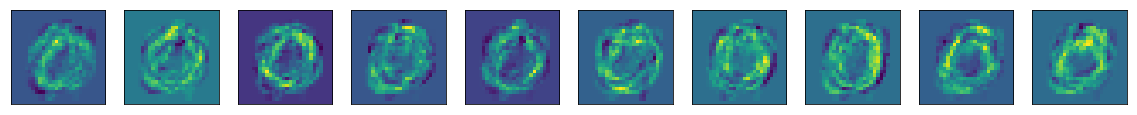

Generated Images in Y View


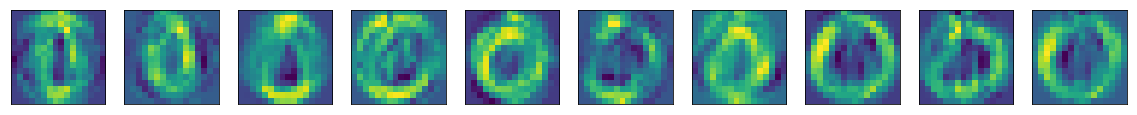

Set  1
X-view


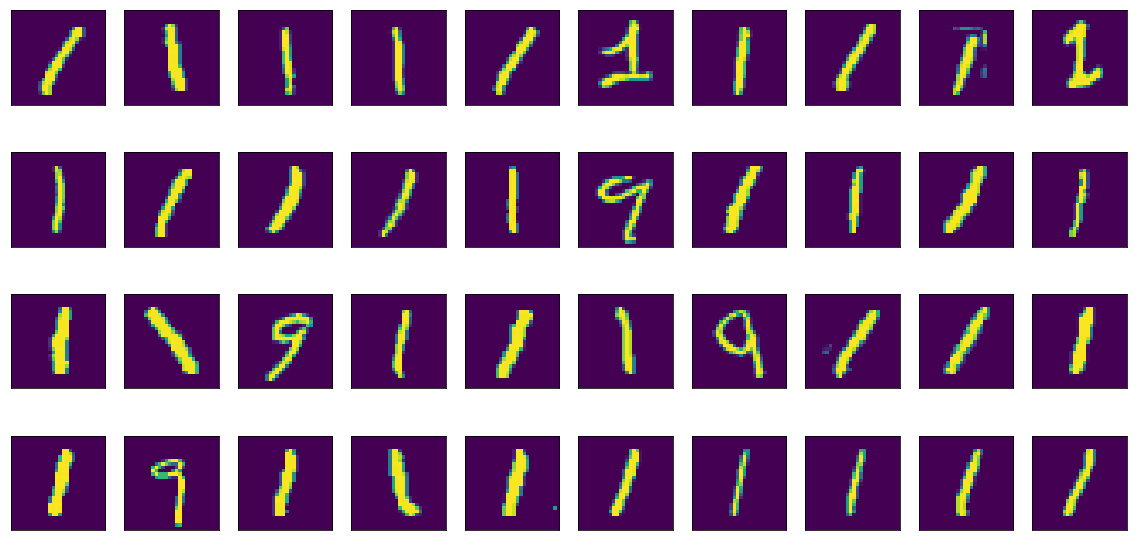

Y-view


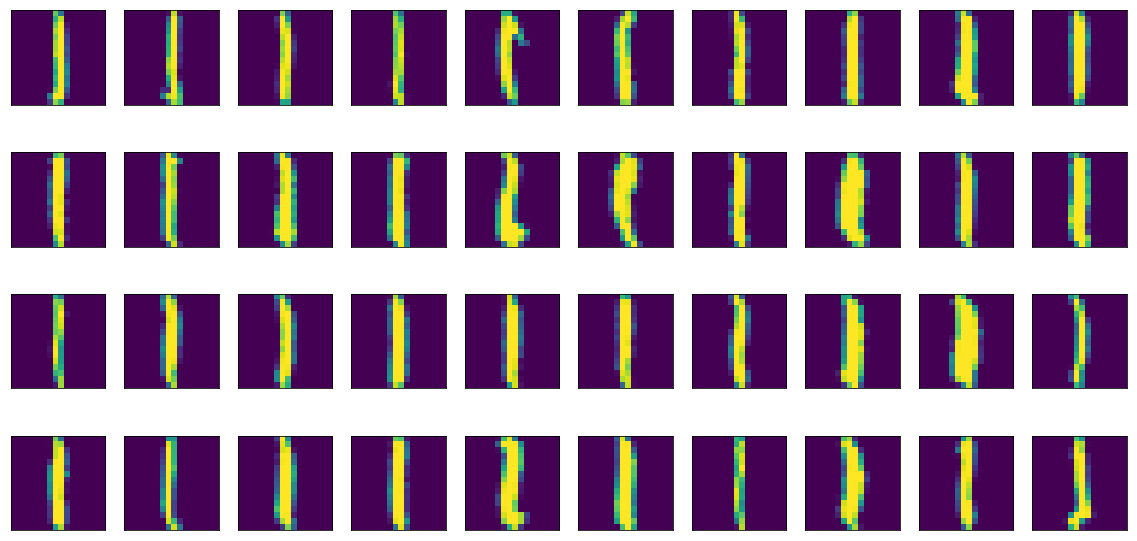

Iteration  0 / 100
After convergence error in XNy and YNx view is -  9.607228959104348e-14 2.3946630044781804e-18
Iteration  1 / 100
After convergence error in XNy and YNx view is -  2.7836341415708534e-11 1.225961946838008e-15
Iteration  2 / 100
After convergence error in XNy and YNx view is -  2.782930110105975e-11 1.2256105442595981e-15
Iteration  3 / 100
After convergence error in XNy and YNx view is -  2.7822263660321547e-11 1.2252593203868543e-15
Iteration  4 / 100
After convergence error in XNy and YNx view is -  2.7815228398514376e-11 1.2249082222638787e-15
Iteration  5 / 100
After convergence error in XNy and YNx view is -  2.7808194758875236e-11 1.2245571470444713e-15
Iteration  6 / 100
After convergence error in XNy and YNx view is -  2.780116244700367e-11 1.2242062101092808e-15
Iteration  7 / 100
After convergence error in XNy and YNx view is -  2.779413243397794e-11 1.223855392758954e-15
Iteration  8 / 100
After convergence error in XNy and YNx view is -  2.778710323589968

Iteration  72 / 100
After convergence error in XNy and YNx view is -  3.9090920097007915e-11 1.7577454863910342e-15
Iteration  73 / 100
After convergence error in XNy and YNx view is -  3.907882552331103e-11 1.757139584331386e-15
Iteration  74 / 100
After convergence error in XNy and YNx view is -  3.906673358034725e-11 1.756533808715732e-15
Iteration  75 / 100
After convergence error in XNy and YNx view is -  3.9054647238881177e-11 1.7559283185162907e-15
Iteration  76 / 100
After convergence error in XNy and YNx view is -  3.9042564277620886e-11 1.755323001999267e-15
Iteration  77 / 100
After convergence error in XNy and YNx view is -  3.903048467442637e-11 1.7547178634257336e-15
Iteration  78 / 100
After convergence error in XNy and YNx view is -  3.9018409968358356e-11 1.7541129914784025e-15
Iteration  79 / 100
After convergence error in XNy and YNx view is -  3.900634012560779e-11 1.753508437124828e-15
Iteration  80 / 100
After convergence error in XNy and YNx view is -  3.89942733

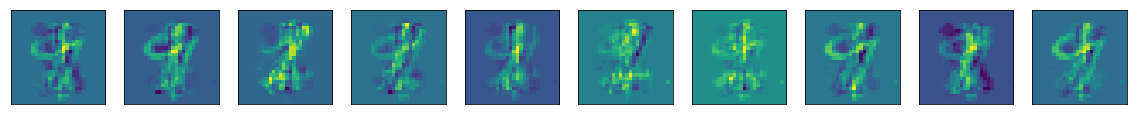

Generated Images in Y View


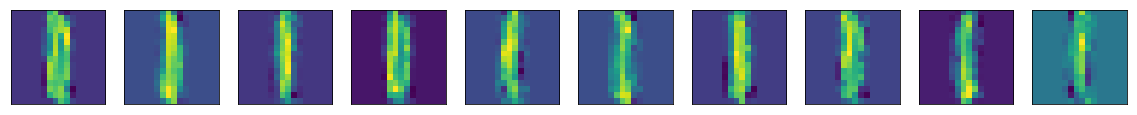

Set  2
X-view


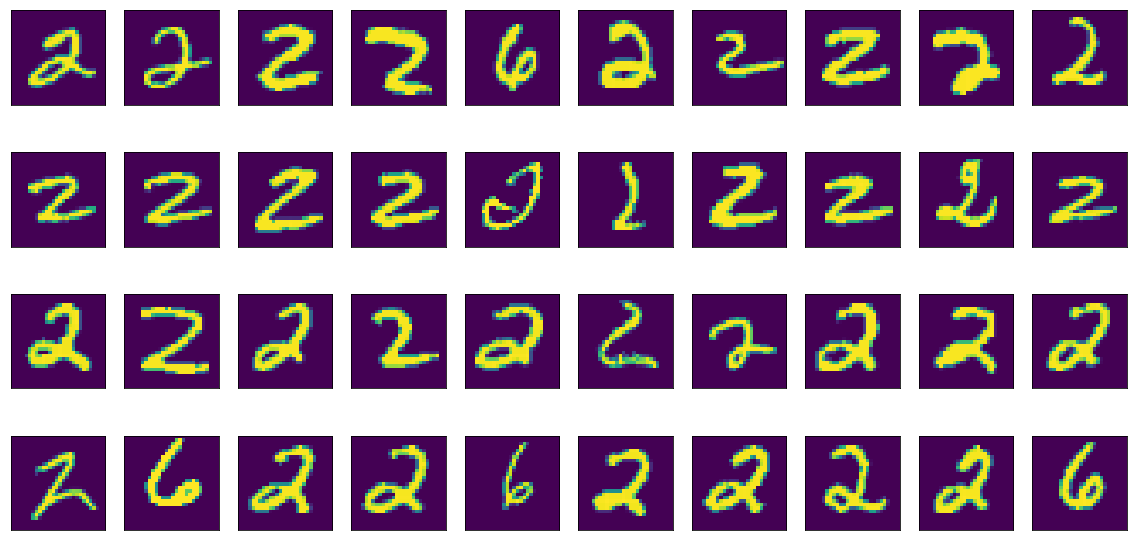

Y-view


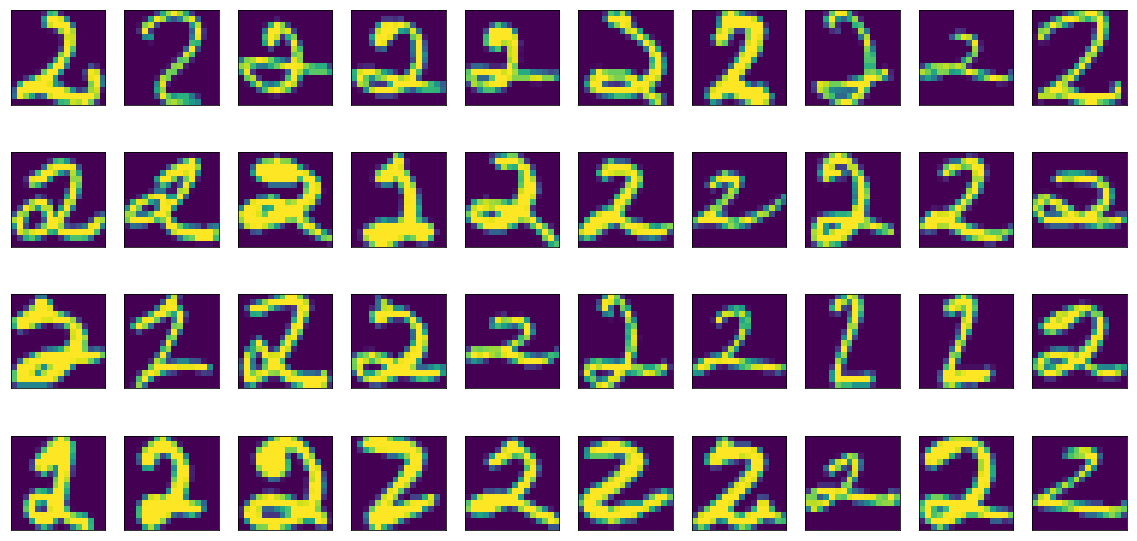

Iteration  0 / 100
After convergence error in XNy and YNx view is -  4.762826309464196e-15 3.5316041486662193e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  5.189111853674058e-14 3.462304150566419e-18
Iteration  2 / 100
After convergence error in XNy and YNx view is -  5.1890767124249096e-14 3.4622743207697787e-18
Iteration  3 / 100
After convergence error in XNy and YNx view is -  5.189039619848698e-14 3.4622443490287477e-18
Iteration  4 / 100
After convergence error in XNy and YNx view is -  5.189000484733845e-14 3.4622121249084975e-18
Iteration  5 / 100
After convergence error in XNy and YNx view is -  5.1889644475514355e-14 3.4621825896096542e-18
Iteration  6 / 100
After convergence error in XNy and YNx view is -  5.188925831781116e-14 3.462149949437687e-18
Iteration  7 / 100
After convergence error in XNy and YNx view is -  5.188888846768146e-14 3.4621189697978626e-18
Iteration  8 / 100
After convergence error in XNy and YNx view is -  5.1888532137884947e

Iteration  72 / 100
After convergence error in XNy and YNx view is -  5.186455287634631e-14 3.460114506172913e-18
Iteration  73 / 100
After convergence error in XNy and YNx view is -  5.1864168894351664e-14 3.4600837364600458e-18
Iteration  74 / 100
After convergence error in XNy and YNx view is -  5.1863799276642075e-14 3.4600524940145e-18
Iteration  75 / 100
After convergence error in XNy and YNx view is -  5.186341911291872e-14 3.460021718948438e-18
Iteration  76 / 100
After convergence error in XNy and YNx view is -  5.1863059888625415e-14 3.459991884696829e-18
Iteration  77 / 100
After convergence error in XNy and YNx view is -  5.1862688285174664e-14 3.4599608822518386e-18
Iteration  78 / 100
After convergence error in XNy and YNx view is -  5.1862296550512966e-14 3.459928554989247e-18
Iteration  79 / 100
After convergence error in XNy and YNx view is -  5.186192229872123e-14 3.459898686691506e-18
Iteration  80 / 100
After convergence error in XNy and YNx view is -  5.18615581586

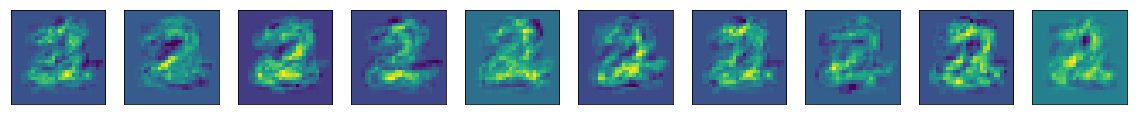

Generated Images in Y View


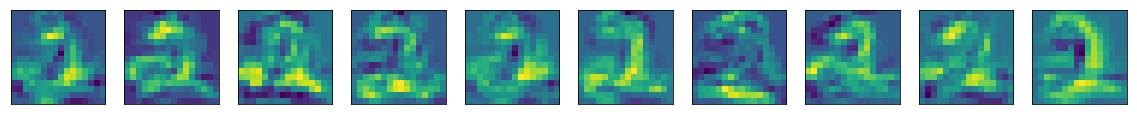

Set  3
X-view


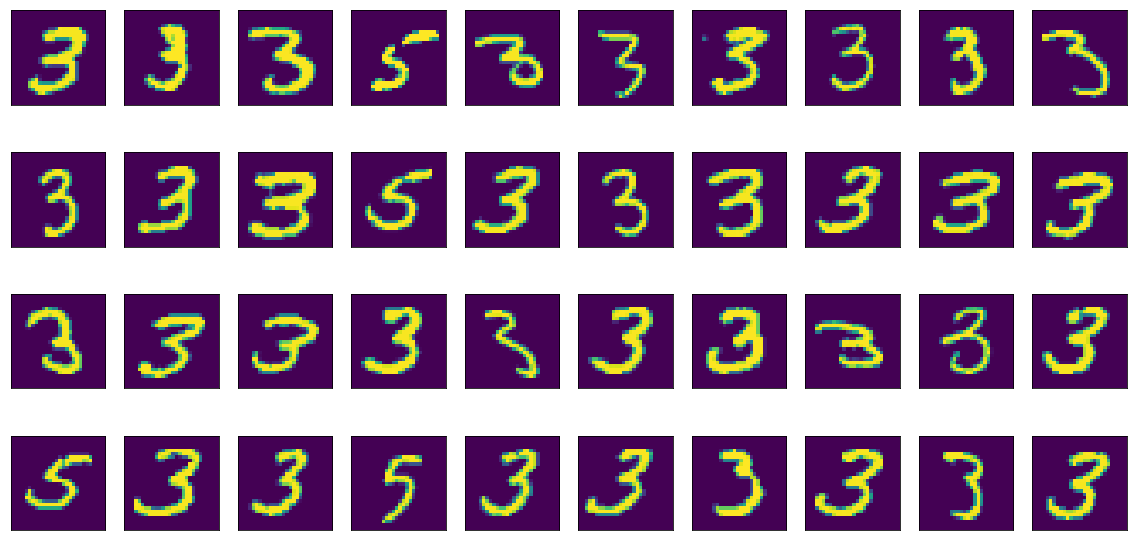

Y-view


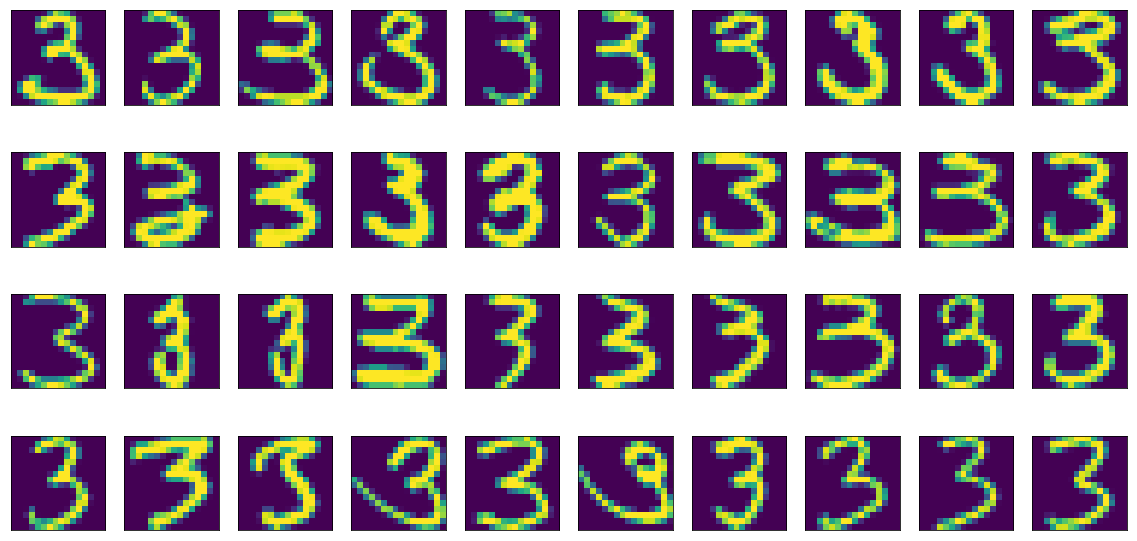

Iteration  0 / 100
After convergence error in XNy and YNx view is -  4.87274741708487e-15 2.9181608910882493e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  6.098228765325422e-14 5.623442583603467e-18
Iteration  2 / 100
After convergence error in XNy and YNx view is -  6.098162785322428e-14 5.623347439223443e-18
Iteration  3 / 100
After convergence error in XNy and YNx view is -  6.098099579573746e-14 5.6232529706799605e-18
Iteration  4 / 100
After convergence error in XNy and YNx view is -  6.098032787101539e-14 5.62315637464202e-18
Iteration  5 / 100
After convergence error in XNy and YNx view is -  6.097967502103017e-14 5.623061596506871e-18
Iteration  6 / 100
After convergence error in XNy and YNx view is -  6.097901868340474e-14 5.622966937010998e-18
Iteration  7 / 100
After convergence error in XNy and YNx view is -  6.097838750062238e-14 5.622873334444342e-18
Iteration  8 / 100
After convergence error in XNy and YNx view is -  6.097773169058903e-14 5.622

Iteration  72 / 100
After convergence error in XNy and YNx view is -  6.09361697929189e-14 5.616705250420182e-18
Iteration  73 / 100
After convergence error in XNy and YNx view is -  6.093554573254191e-14 5.6166135271330806e-18
Iteration  74 / 100
After convergence error in XNy and YNx view is -  6.093488188915639e-14 5.6165170277682986e-18
Iteration  75 / 100
After convergence error in XNy and YNx view is -  6.093424960872944e-14 5.616424636662785e-18
Iteration  76 / 100
After convergence error in XNy and YNx view is -  6.093359315176527e-14 5.616328704113153e-18
Iteration  77 / 100
After convergence error in XNy and YNx view is -  6.093294319312811e-14 5.616232495032322e-18
Iteration  78 / 100
After convergence error in XNy and YNx view is -  6.093230277754708e-14 5.6161397952237525e-18
Iteration  79 / 100
After convergence error in XNy and YNx view is -  6.093163135470689e-14 5.6160411260256125e-18
Iteration  80 / 100
After convergence error in XNy and YNx view is -  6.0930983470850

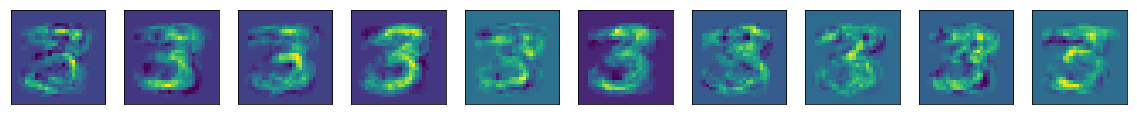

Generated Images in Y View


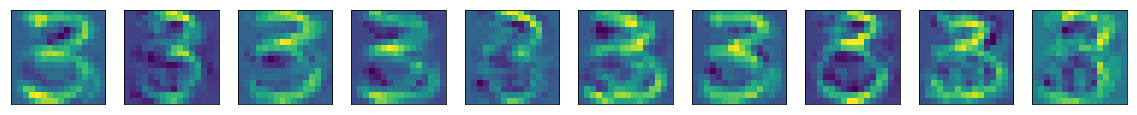

Set  4
X-view


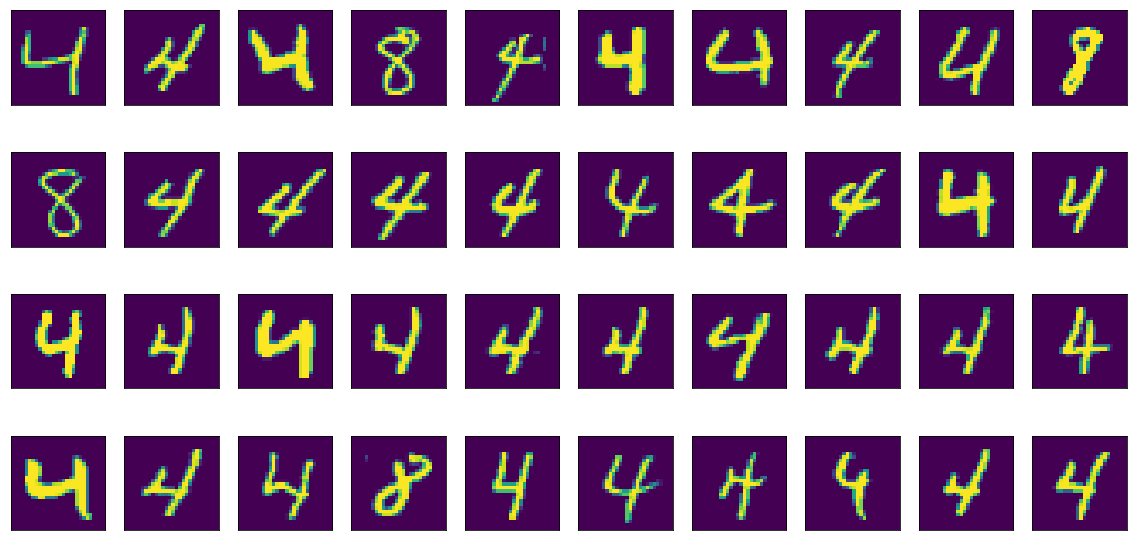

Y-view


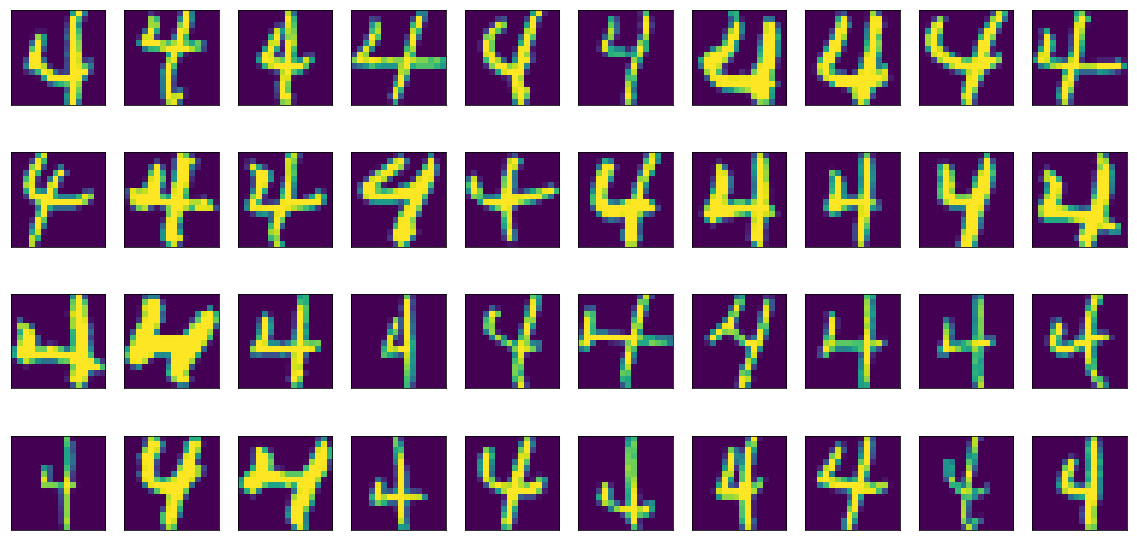

Iteration  0 / 100
After convergence error in XNy and YNx view is -  9.521658927009641e-15 6.209146821169935e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  3.752019347966198e-12 9.763696033344374e-17
Iteration  2 / 100
After convergence error in XNy and YNx view is -  3.751663835381939e-12 9.762789845988899e-17
Iteration  3 / 100
After convergence error in XNy and YNx view is -  3.7513080383373986e-12 9.761883621706494e-17
Iteration  4 / 100
After convergence error in XNy and YNx view is -  3.750952112354387e-12 9.76097728423233e-17
Iteration  5 / 100
After convergence error in XNy and YNx view is -  3.750596361733081e-12 9.76007120772591e-17
Iteration  6 / 100
After convergence error in XNy and YNx view is -  3.7502405735661486e-12 9.759165529355738e-17
Iteration  7 / 100
After convergence error in XNy and YNx view is -  3.749885073001495e-12 9.758259769236151e-17
Iteration  8 / 100
After convergence error in XNy and YNx view is -  3.749529757659256e-12 9.757

Iteration  72 / 100
After convergence error in XNy and YNx view is -  3.726847198228542e-12 9.699581833063482e-17
Iteration  73 / 100
After convergence error in XNy and YNx view is -  3.726493862188434e-12 9.698681467401847e-17
Iteration  74 / 100
After convergence error in XNy and YNx view is -  3.7261407074298474e-12 9.697781944927478e-17
Iteration  75 / 100
After convergence error in XNy and YNx view is -  3.7257875304906304e-12 9.696882260855487e-17
Iteration  76 / 100
After convergence error in XNy and YNx view is -  3.725434305619828e-12 9.695982755871129e-17
Iteration  77 / 100
After convergence error in XNy and YNx view is -  3.725081598248151e-12 9.695083721642129e-17
Iteration  78 / 100
After convergence error in XNy and YNx view is -  3.724728157584796e-12 9.694183981877685e-17
Iteration  79 / 100
After convergence error in XNy and YNx view is -  3.7243748824146045e-12 9.693284344092427e-17
Iteration  80 / 100
After convergence error in XNy and YNx view is -  3.7240222578067

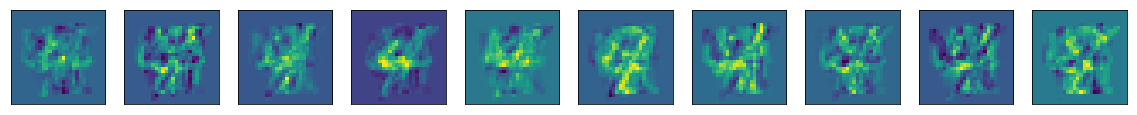

Generated Images in Y View


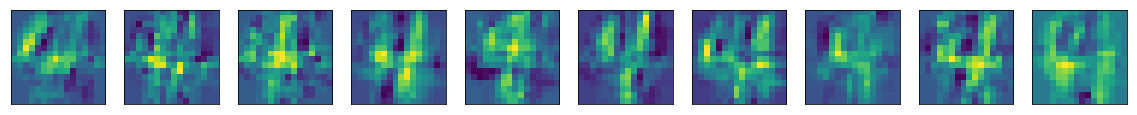

Set  5
X-view


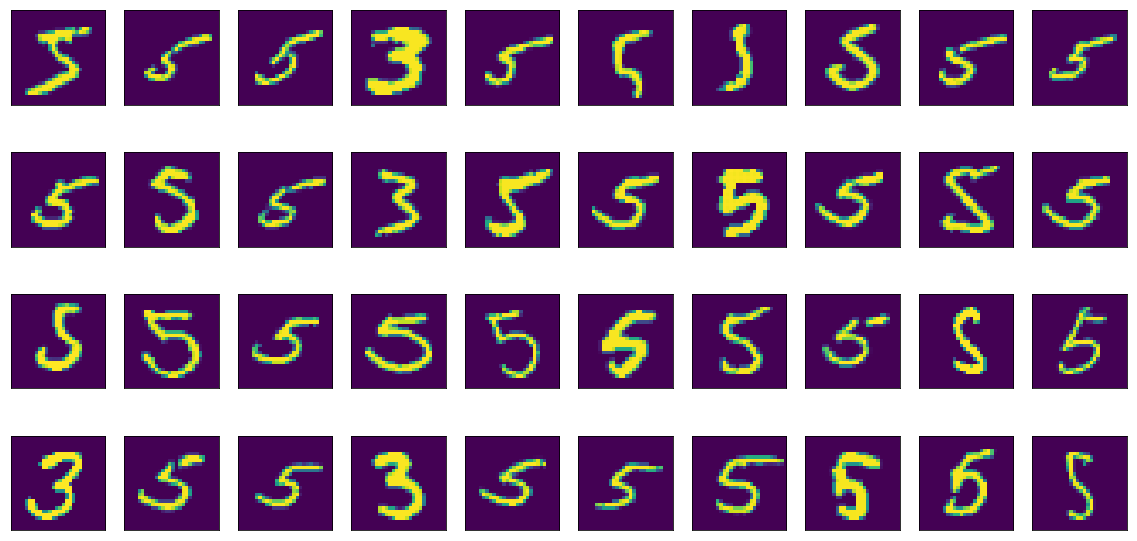

Y-view


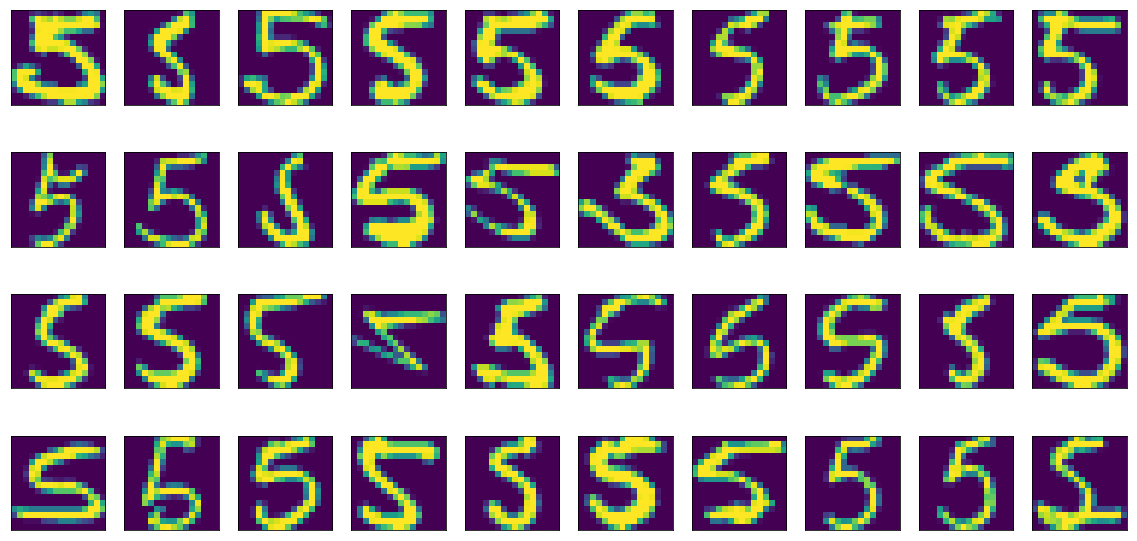

Iteration  0 / 100
After convergence error in XNy and YNx view is -  5.757148377158317e-15 3.3688308806308694e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  3.178411831448577e-13 1.738326470236666e-17
Iteration  2 / 100
After convergence error in XNy and YNx view is -  3.178347322441108e-13 1.738286293495544e-17
Iteration  3 / 100
After convergence error in XNy and YNx view is -  3.1782836224304504e-13 1.7382467317081957e-17
Iteration  4 / 100
After convergence error in XNy and YNx view is -  3.1782192773051164e-13 1.7382066193733743e-17
Iteration  5 / 100
After convergence error in XNy and YNx view is -  3.178155085870008e-13 1.7381665158864942e-17
Iteration  6 / 100
After convergence error in XNy and YNx view is -  3.178090725123276e-13 1.7381264707826602e-17
Iteration  7 / 100
After convergence error in XNy and YNx view is -  3.1780267753292124e-13 1.7380866490643128e-17
Iteration  8 / 100
After convergence error in XNy and YNx view is -  3.1779626028909125

Iteration  72 / 100
After convergence error in XNy and YNx view is -  2.9430324291023606e-13 1.545439349383862e-17
Iteration  73 / 100
After convergence error in XNy and YNx view is -  2.942974885545382e-13 1.545404950535876e-17
Iteration  74 / 100
After convergence error in XNy and YNx view is -  2.9429175698723033e-13 1.5453708899564978e-17
Iteration  75 / 100
After convergence error in XNy and YNx view is -  2.942859995393552e-13 1.5453365153634582e-17
Iteration  76 / 100
After convergence error in XNy and YNx view is -  2.942801980438776e-13 1.5453019486998606e-17
Iteration  77 / 100
After convergence error in XNy and YNx view is -  2.9427446269139186e-13 1.5452677112377838e-17
Iteration  78 / 100
After convergence error in XNy and YNx view is -  2.9426868154309377e-13 1.5452333214218735e-17
Iteration  79 / 100
After convergence error in XNy and YNx view is -  2.9426292115141717e-13 1.5451988386147004e-17
Iteration  80 / 100
After convergence error in XNy and YNx view is -  2.94257

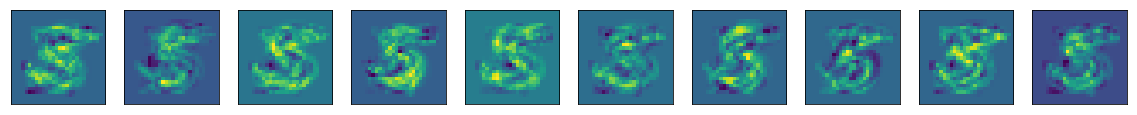

Generated Images in Y View


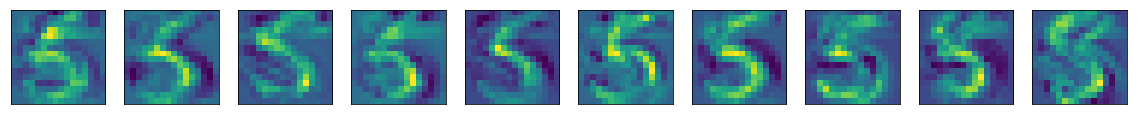

Set  6
X-view


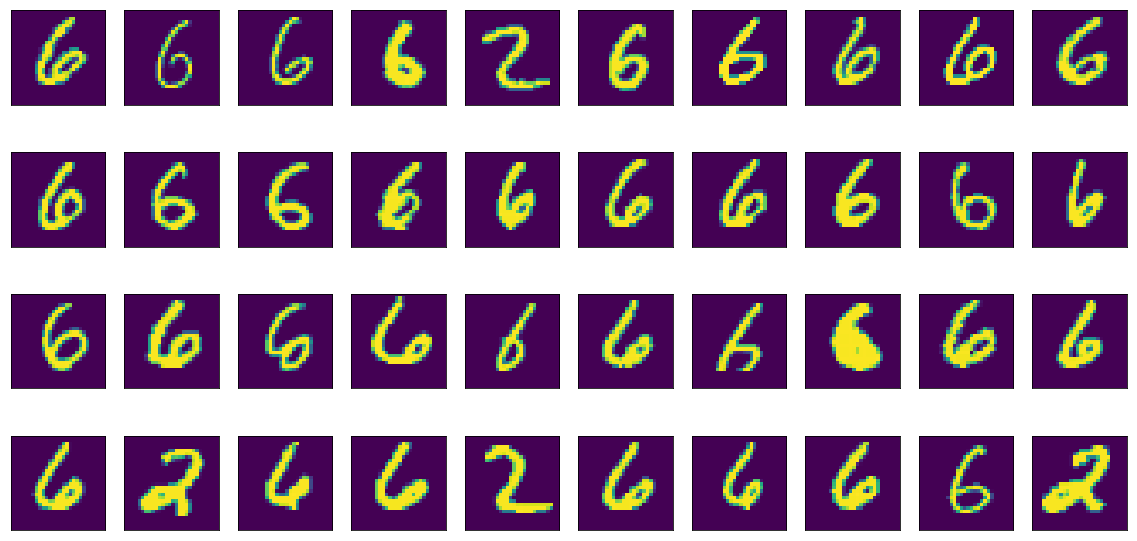

Y-view


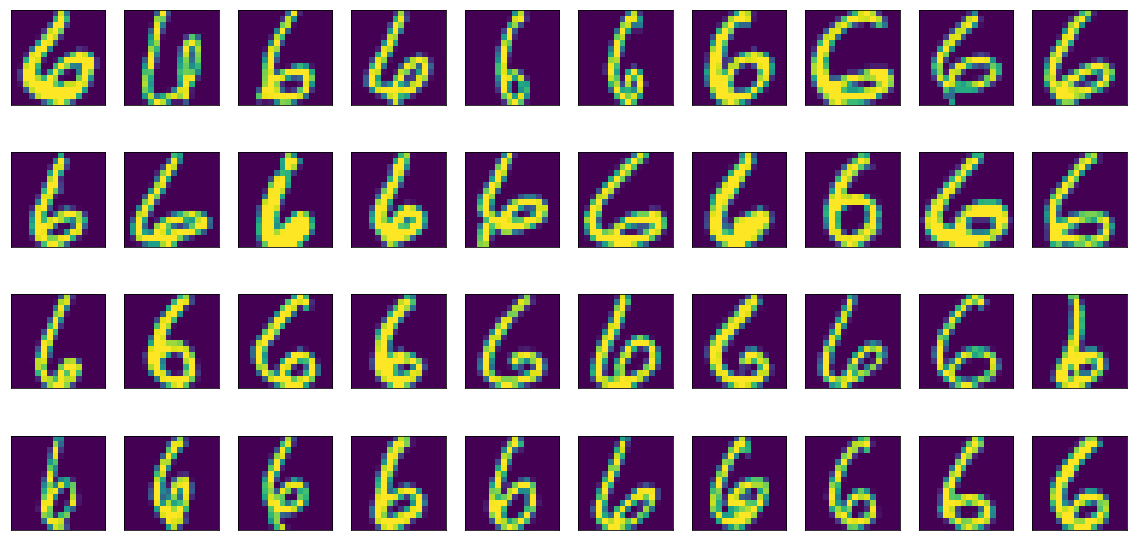

Iteration  0 / 100
After convergence error in XNy and YNx view is -  1.9168871824718814e-14 9.021921820753731e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  3.458496591292915e-13 2.294646208977083e-17
Iteration  2 / 100
After convergence error in XNy and YNx view is -  3.45840280120749e-13 2.294575306020341e-17
Iteration  3 / 100
After convergence error in XNy and YNx view is -  3.458308928874113e-13 2.2945045392046873e-17
Iteration  4 / 100
After convergence error in XNy and YNx view is -  3.458214624093558e-13 2.294433555023305e-17
Iteration  5 / 100
After convergence error in XNy and YNx view is -  3.4581205847056923e-13 2.294362478953845e-17
Iteration  6 / 100
After convergence error in XNy and YNx view is -  3.4580258594585024e-13 2.2942910202369615e-17
Iteration  7 / 100
After convergence error in XNy and YNx view is -  3.457931937047962e-13 2.294220036481826e-17
Iteration  8 / 100
After convergence error in XNy and YNx view is -  3.4578376810890814e-13 

Iteration  72 / 100
After convergence error in XNy and YNx view is -  3.4518184618605675e-13 2.2896080231924274e-17
Iteration  73 / 100
After convergence error in XNy and YNx view is -  3.4517244967567844e-13 2.2895370219972937e-17
Iteration  74 / 100
After convergence error in XNy and YNx view is -  3.45163072663341e-13 2.289466296980373e-17
Iteration  75 / 100
After convergence error in XNy and YNx view is -  3.451536482404572e-13 2.2893953692164602e-17
Iteration  76 / 100
After convergence error in XNy and YNx view is -  3.451442194982877e-13 2.289324411684227e-17
Iteration  77 / 100
After convergence error in XNy and YNx view is -  3.4513485820804343e-13 2.2892533953098718e-17
Iteration  78 / 100
After convergence error in XNy and YNx view is -  3.4512550174006867e-13 2.2891828995799214e-17
Iteration  79 / 100
After convergence error in XNy and YNx view is -  3.4511608174761554e-13 2.289111820612587e-17
Iteration  80 / 100
After convergence error in XNy and YNx view is -  3.4510665

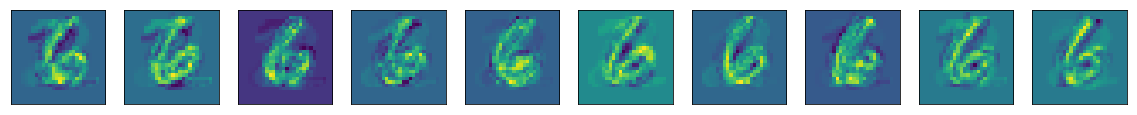

Generated Images in Y View


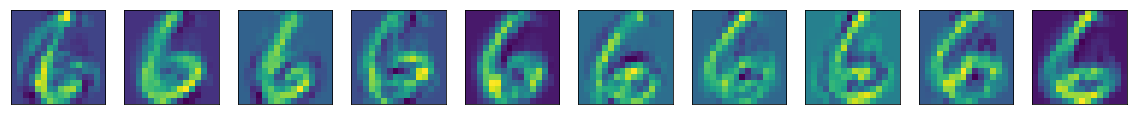

Set  7
X-view


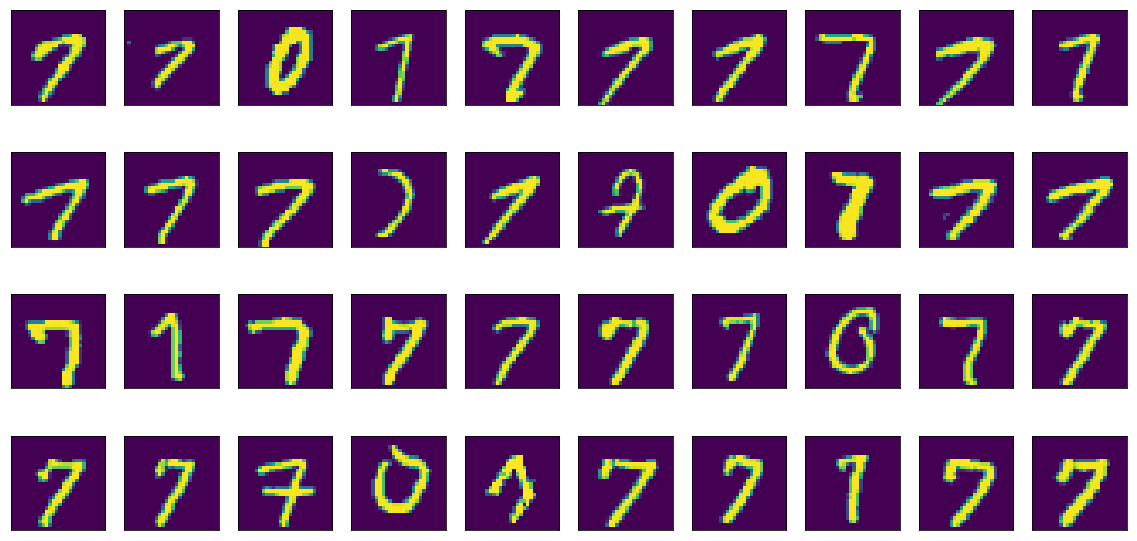

Y-view


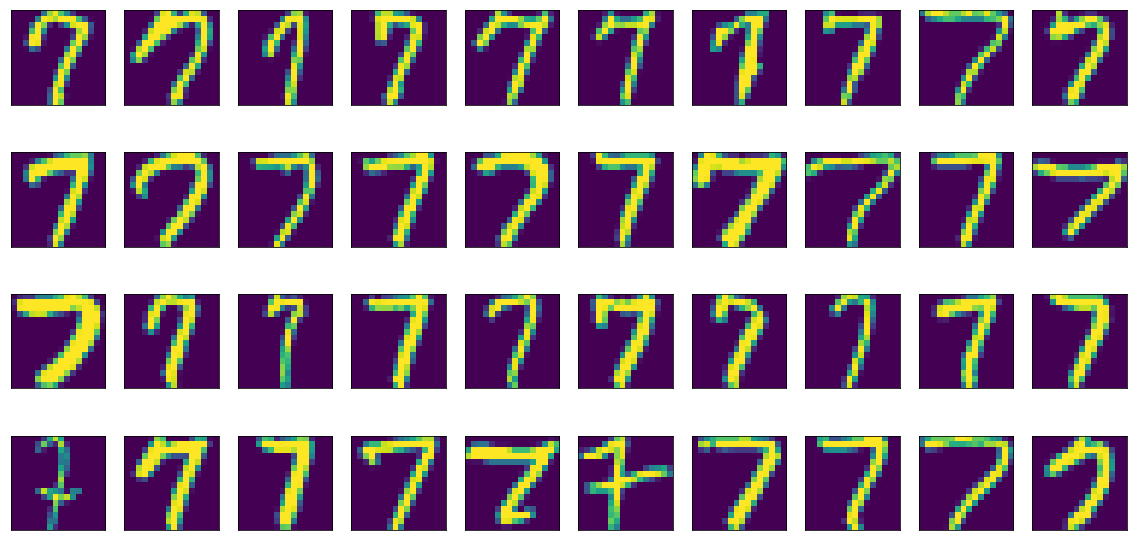

Iteration  0 / 100
After convergence error in XNy and YNx view is -  9.866190735666307e-15 5.356747261001676e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  2.449194000705259e-13 1.8894119671693996e-17
Iteration  2 / 100
After convergence error in XNy and YNx view is -  2.4491455181784745e-13 1.889358317934341e-17
Iteration  3 / 100
After convergence error in XNy and YNx view is -  2.449096797118938e-13 1.889304942167683e-17
Iteration  4 / 100
After convergence error in XNy and YNx view is -  2.449047679990053e-13 1.8892510397267297e-17
Iteration  5 / 100
After convergence error in XNy and YNx view is -  2.4489992758582006e-13 1.8891977630074115e-17
Iteration  6 / 100
After convergence error in XNy and YNx view is -  2.448950707284779e-13 1.889144003564464e-17
Iteration  7 / 100
After convergence error in XNy and YNx view is -  2.4489020433893753e-13 1.8890903582062306e-17
Iteration  8 / 100
After convergence error in XNy and YNx view is -  2.4488533550123403e-

Iteration  72 / 100
After convergence error in XNy and YNx view is -  2.445738540991108e-13 1.8856115912406722e-17
Iteration  73 / 100
After convergence error in XNy and YNx view is -  2.445690223045995e-13 1.885558310128148e-17
Iteration  74 / 100
After convergence error in XNy and YNx view is -  2.445641395494035e-13 1.8855047092692704e-17
Iteration  75 / 100
After convergence error in XNy and YNx view is -  2.445592628227515e-13 1.8854509292600236e-17
Iteration  76 / 100
After convergence error in XNy and YNx view is -  2.4455442207619076e-13 1.8853977301131968e-17
Iteration  77 / 100
After convergence error in XNy and YNx view is -  2.445495906218813e-13 1.8853446112589197e-17
Iteration  78 / 100
After convergence error in XNy and YNx view is -  2.4454472287917933e-13 1.885290931270276e-17
Iteration  79 / 100
After convergence error in XNy and YNx view is -  2.445398620360771e-13 1.8852373674180768e-17
Iteration  80 / 100
After convergence error in XNy and YNx view is -  2.44534997

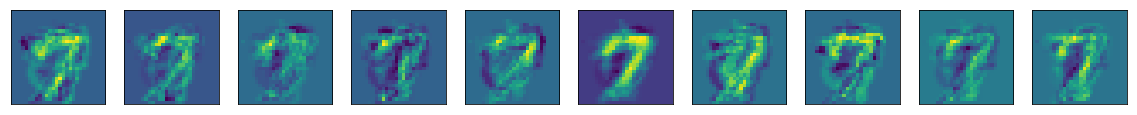

Generated Images in Y View


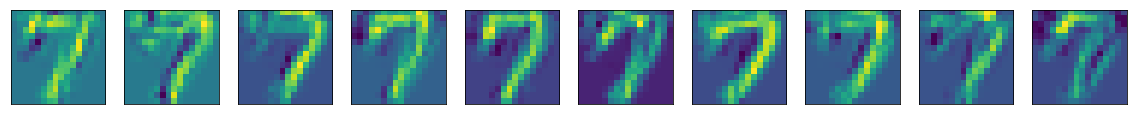

Set  8
X-view


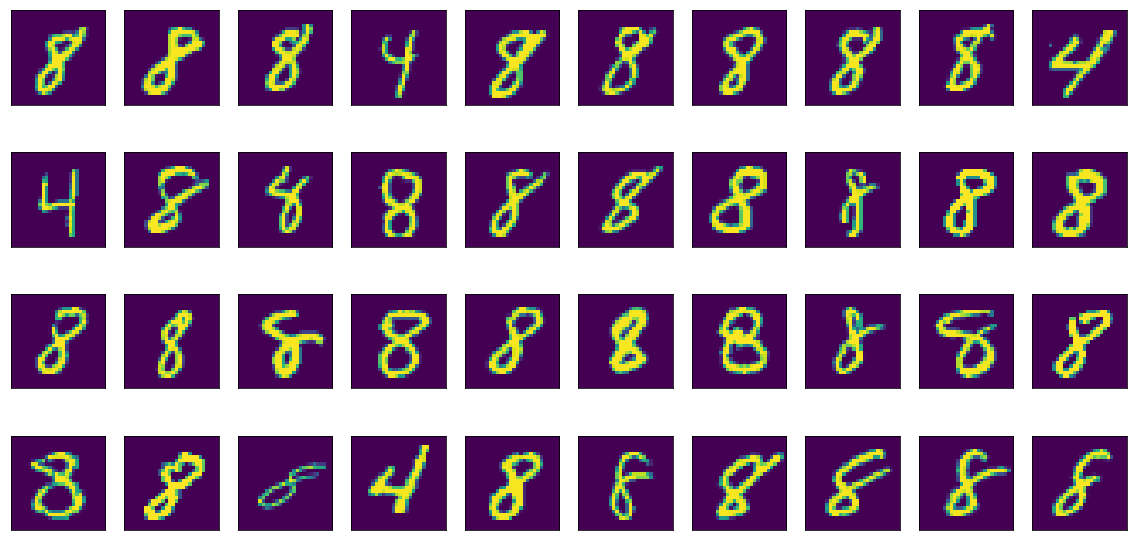

Y-view


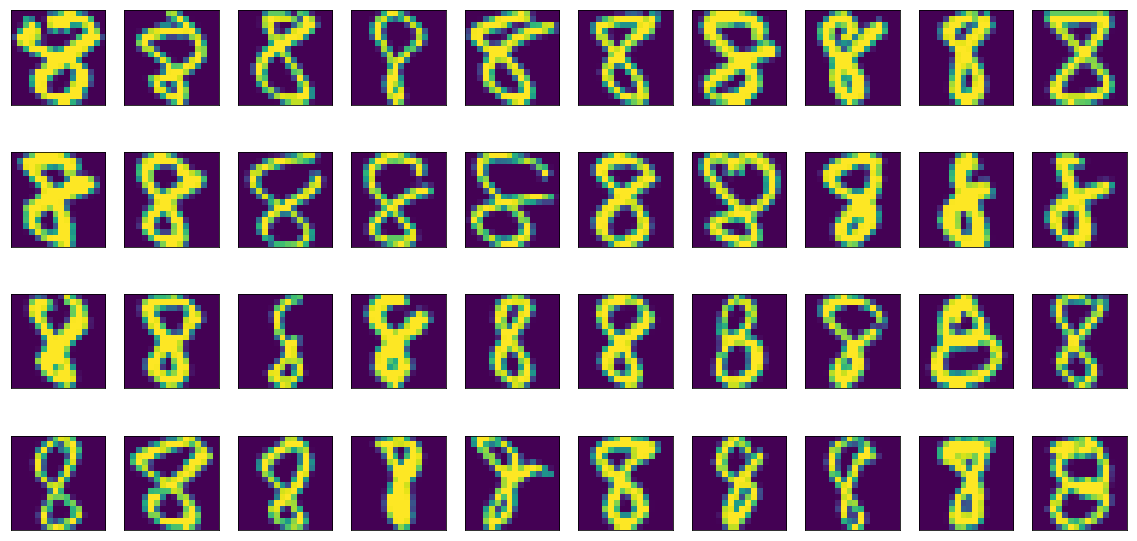

Iteration  0 / 100
After convergence error in XNy and YNx view is -  3.955231156939708e-15 2.4764834577047016e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  8.736251806084672e-14 4.817766888781835e-18
Iteration  2 / 100
After convergence error in XNy and YNx view is -  8.736158956262653e-14 4.817697689708301e-18
Iteration  3 / 100
After convergence error in XNy and YNx view is -  8.73606923693424e-14 4.8176306791484976e-18
Iteration  4 / 100
After convergence error in XNy and YNx view is -  8.735975360979876e-14 4.8175618883682214e-18
Iteration  5 / 100
After convergence error in XNy and YNx view is -  8.735885874115673e-14 4.8174946136507026e-18
Iteration  6 / 100
After convergence error in XNy and YNx view is -  8.735794137709022e-14 4.817426416146752e-18
Iteration  7 / 100
After convergence error in XNy and YNx view is -  8.735701140205669e-14 4.8173573773604776e-18
Iteration  8 / 100
After convergence error in XNy and YNx view is -  8.735609679830175e-14 4

Iteration  72 / 100
After convergence error in XNy and YNx view is -  8.729749427313236e-14 4.8129335933925614e-18
Iteration  73 / 100
After convergence error in XNy and YNx view is -  8.729655198670977e-14 4.812865115033132e-18
Iteration  74 / 100
After convergence error in XNy and YNx view is -  8.729567587695733e-14 4.812797862709176e-18
Iteration  75 / 100
After convergence error in XNy and YNx view is -  8.729474983914155e-14 4.812730290546358e-18
Iteration  76 / 100
After convergence error in XNy and YNx view is -  8.729380606947306e-14 4.8126609188223914e-18
Iteration  77 / 100
After convergence error in XNy and YNx view is -  8.729289770070162e-14 4.812592475560842e-18
Iteration  78 / 100
After convergence error in XNy and YNx view is -  8.729197165522046e-14 4.8125246454825255e-18
Iteration  79 / 100
After convergence error in XNy and YNx view is -  8.729109286809708e-14 4.812458650047799e-18
Iteration  80 / 100
After convergence error in XNy and YNx view is -  8.7290173605023

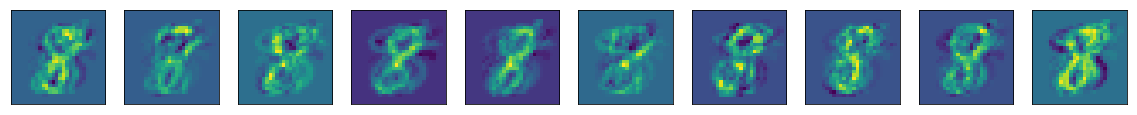

Generated Images in Y View


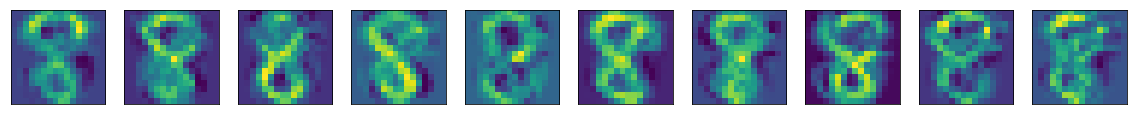

Set  9
X-view


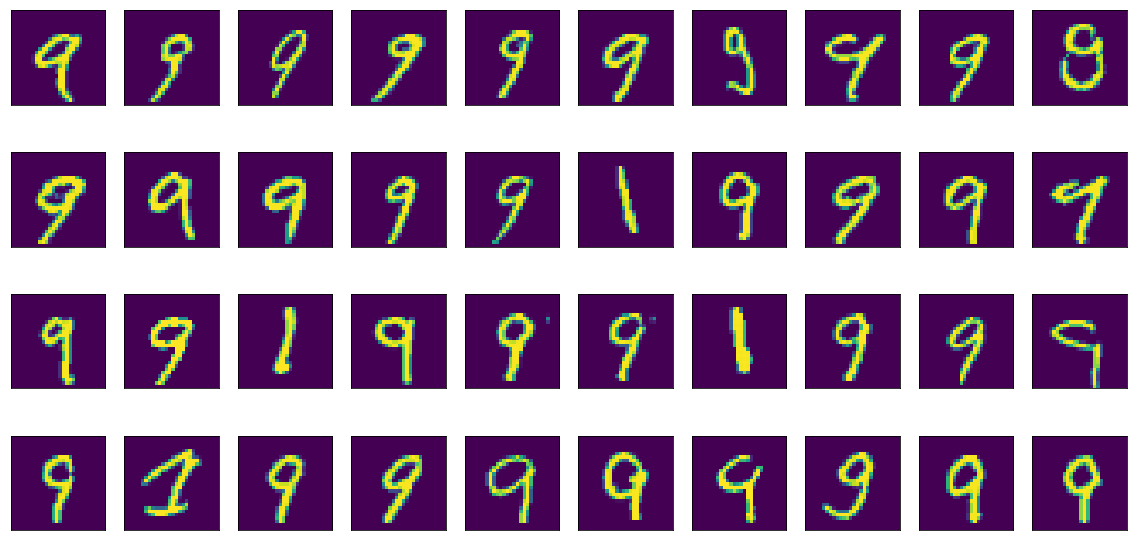

Y-view


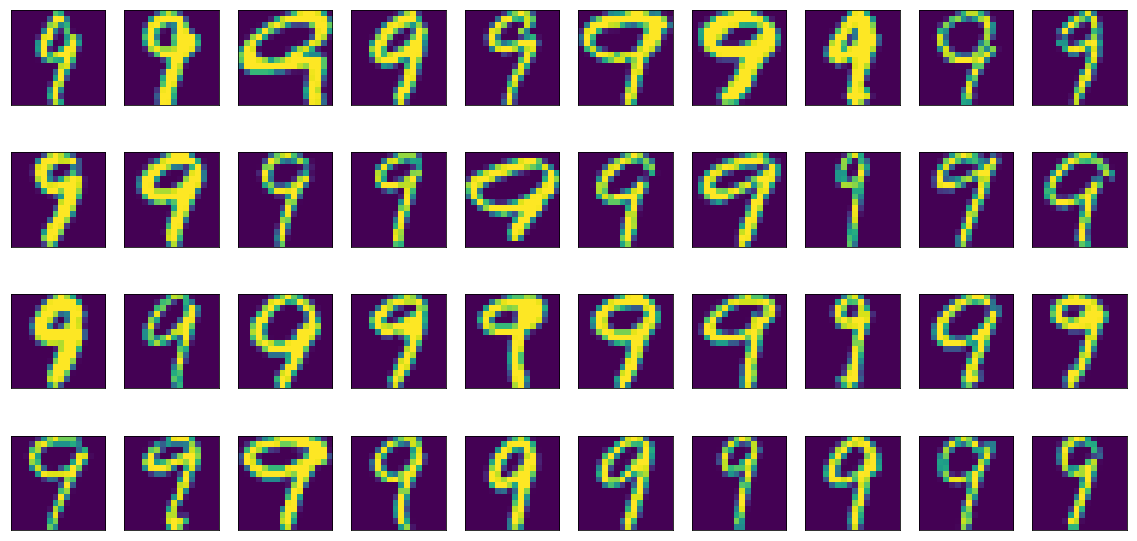

Iteration  0 / 100
After convergence error in XNy and YNx view is -  1.3092225337750127e-14 1.6472124496026235e-19
Iteration  1 / 100
After convergence error in XNy and YNx view is -  1.0229496017392867e-13 1.6146286729862782e-18
Iteration  2 / 100
After convergence error in XNy and YNx view is -  1.0229400852082087e-13 1.6146083197412337e-18
Iteration  3 / 100
After convergence error in XNy and YNx view is -  1.0229307900005225e-13 1.6145874595126984e-18
Iteration  4 / 100
After convergence error in XNy and YNx view is -  1.0229213359691777e-13 1.6145670245097893e-18
Iteration  5 / 100
After convergence error in XNy and YNx view is -  1.0229116999184205e-13 1.6145460108389718e-18
Iteration  6 / 100
After convergence error in XNy and YNx view is -  1.0229021971605059e-13 1.6145256501841585e-18
Iteration  7 / 100
After convergence error in XNy and YNx view is -  1.0228926199000111e-13 1.6145050546240548e-18
Iteration  8 / 100
After convergence error in XNy and YNx view is -  1.022883316

Iteration  71 / 100
After convergence error in XNy and YNx view is -  1.0222872232364941e-13 1.613188872983422e-18
Iteration  72 / 100
After convergence error in XNy and YNx view is -  1.0222776695316432e-13 1.61316824157107e-18
Iteration  73 / 100
After convergence error in XNy and YNx view is -  1.0222680852023345e-13 1.6131475559003755e-18
Iteration  74 / 100
After convergence error in XNy and YNx view is -  1.0222588549474275e-13 1.6131272914600546e-18
Iteration  75 / 100
After convergence error in XNy and YNx view is -  1.0222494511947635e-13 1.6131067006693532e-18
Iteration  76 / 100
After convergence error in XNy and YNx view is -  1.0222402454236194e-13 1.6130864028068986e-18
Iteration  77 / 100
After convergence error in XNy and YNx view is -  1.0222306231738357e-13 1.6130657922914751e-18
Iteration  78 / 100
After convergence error in XNy and YNx view is -  1.022221165589636e-13 1.6130447842764016e-18
Iteration  79 / 100
After convergence error in XNy and YNx view is -  1.0222

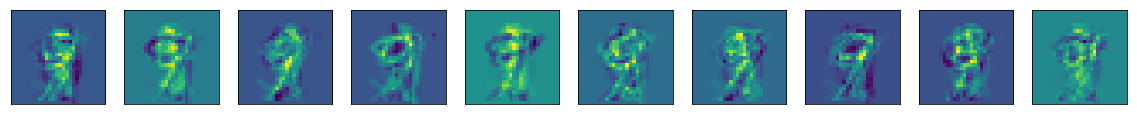

Generated Images in Y View


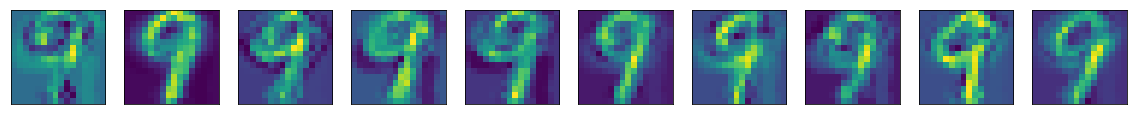

Wall time: 1h 11min 26s


In [11]:
%%time
# neighbour_list = []
data_usps = usps_read("usps.h5")
data_mnist = mnist_read("mnist_train.csv")

# scaler = MinMaxScaler()
# scaler.fit(data_usps)
# data_usps = scaler.fit_transform(data_usps)
# scaler.fit(data_mnist)
# data_mnist = scaler.fit_transform(data_mnist)

view1 = generateSamples(data_mnist)
view2 = generateSamples(data_usps)
Views = []
Views.append(view1)
Views.append(view2)
XNc,YNc,XNx,YNy = generatePartialData(Views)
XNc,XNx,outliers_index = generateOutliers(XNc,XNx)

S,X,Y = [],[],[]
l1 = [1,2,3,4,7]
l2 = [9,6,5,8,0]
size = 50
for i in range(0,10):
    print('Set ',i)
    xnc,xnx,xny,ync,yny,ynx = initialization(XNc[i],XNx[i],YNc[i],YNy[i],0.6,size)
    
    print("X-view")
    fig, ax = plt.subplots(4, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
    c = 0
    for i in xnc:
        ax[int(c/10),c%10].imshow(i.reshape(28,28))
        c += 1
    for i in xnx:
        ax[int(c/10),c%10].imshow(i.reshape(28,28))
        c += 1
    plt.show()
    
    print("Y-view")
    fig, ax = plt.subplots(4, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
    c = 0
    for i in ync:
        ax[int(c/10),c%10].imshow(i.reshape(16,16))
        c += 1
    for i in yny:
        ax[int(c/10),c%10].imshow(i.reshape(16,16))
        c += 1
    plt.show()
    
    s,x,y = sampleRecover_OutlierDetection(xnc,xnx,xny,ync,yny,ynx,size,0.6,100,10)
    
    print('Generated Images in X View')
    fig, ax = plt.subplots(1, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
    c = 0
    for j in x[40:50]:
        ax[c].imshow(j.reshape(28,28))
        c = c+1
    plt.show()
    
    print('Generated Images in Y View')
    fig, ax = plt.subplots(1, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
    c = 0
    for j in y[30:40]:
        ax[c].imshow(j.reshape(16,16))
        c = c+1
    plt.show()
    
    S.append(s)
    X.append(x)
    Y.append(y)

No handles with labels found to put in legend.


For set  0
AUC  0.4534883720930233


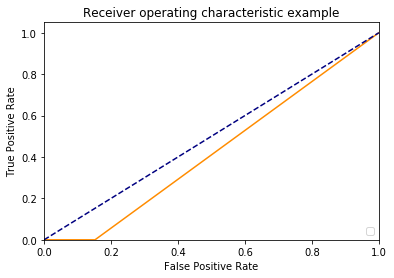

No handles with labels found to put in legend.


For set  1
AUC  0.4473684210526316


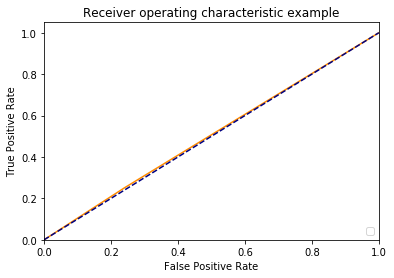

No handles with labels found to put in legend.


For set  2
AUC  0.4583333333333333


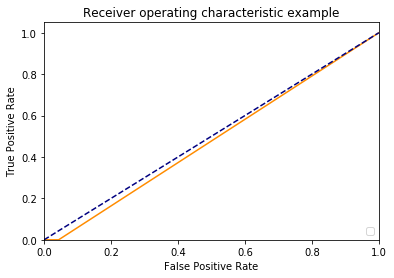

No handles with labels found to put in legend.


For set  3
AUC  0.4583333333333333


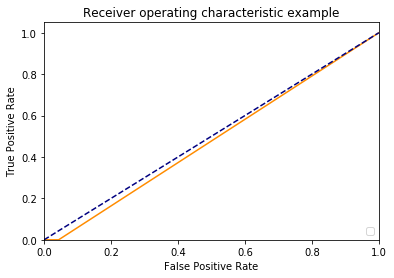

No handles with labels found to put in legend.


For set  4
AUC  0.4574468085106383


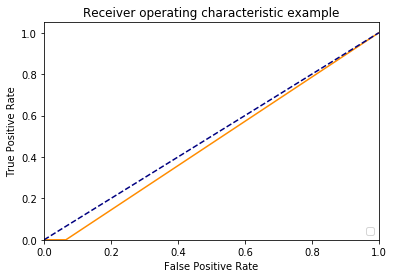

No handles with labels found to put in legend.


For set  5
AUC  0.45454545454545453


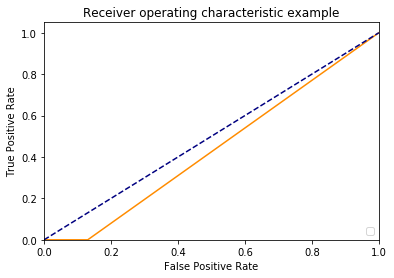

No handles with labels found to put in legend.


For set  6
AUC  0.71875


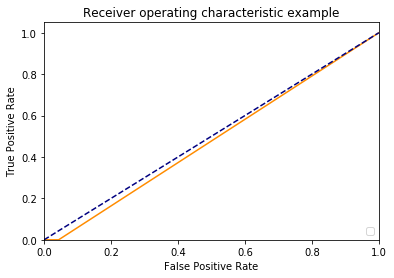

No handles with labels found to put in legend.


For set  7
AUC  0.4583333333333333


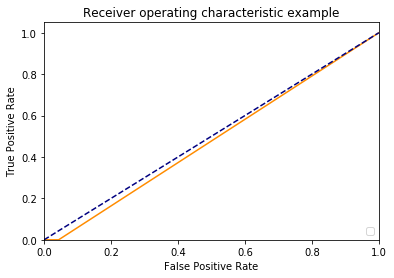

No handles with labels found to put in legend.


For set  8
AUC  0.4583333333333333


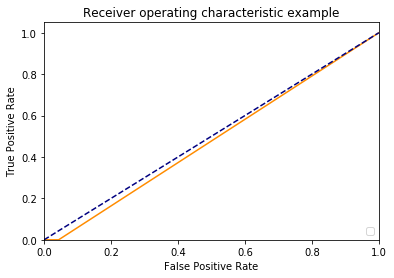

No handles with labels found to put in legend.


For set  9
AUC  0.4574468085106383


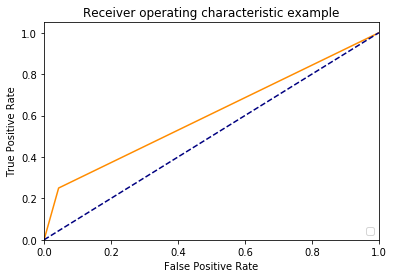

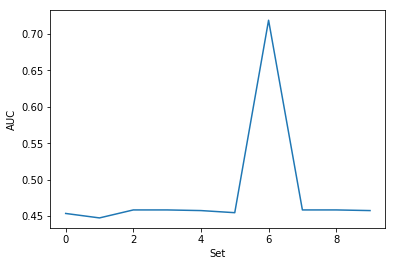

In [23]:
aucs = []
for i in range(0,10):
    outliers_list = np.array([ a<0.3 for a in S[i] ])
    indices = np.array(np.where(outliers_list == 1))[0]
#     print('For set ',i,' outlier are ',len(indices))
    print('For set ',i)
#     print('indices are ',indices)
#     for j in indices:
#         plt.imshow(X[i][j].reshape(28,28))
#         plt.show()
    print("AUC ",roc_auc_score(outliers_list,outliers_index[0]))
    aucs.append(roc_auc_score(outliers_list,outliers_index[0]))
    plt.figure()
    fpr, tpr, thresholds = metrics.roc_curve(outliers_index[i],outliers_list)
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
plt.plot(aucs)
plt.ylabel('AUC')
plt.xlabel('Set')
plt.show()

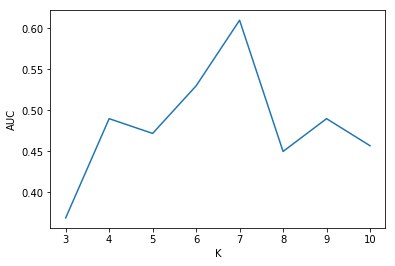

In [21]:
k = [3,4,5,6,7,8,9,10]
aucs = [0.369,0.49,0.472,0.53,0.61,0.45,0.49,0.457]
plt.plot(k,aucs)
plt.ylabel('AUC')
plt.xlabel('K')
plt.show()